In [1]:
%matplotlib inline

import os
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

PROJECTS = ['ant-ivy', 'archiva', 'calcite', 'cayenne', 'commons-bcel', 'commons-beanutils',
            'commons-codec', 'commons-collections', 'commons-compress', 'commons-configuration',
            'commons-dbcp', 'commons-digester', 'commons-io', 'commons-jcs', 'commons-jexl',
            'commons-lang', 'commons-math', 'commons-net', 'commons-scxml', 
            'commons-validator', 'commons-vfs', 'deltaspike', 'eagle', 'giraph', 'gora', 'jspwiki',
            'knox', 'kylin', 'lens', 'mahout', 'manifoldcf','nutch','opennlp','parquet-mr',
            'santuario-java', 'systemml', 'tika', 'wss4j']

DATA_PATH = '../data/'
FIGURES_PATH = '../figures/'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# load interval data data

In [2]:
scores = []
for project_name in PROJECTS:
    fname = '{}/interval_mean_{}.csv'.format(DATA_PATH, project_name)
    if os.path.exists(fname):
        try:
            scores.append(pd.read_csv(fname))
        except pd.errors.EmptyDataError:
            print(fname, 'is empty')

r = pd.concat(scores)

# Logistic regression interval plots

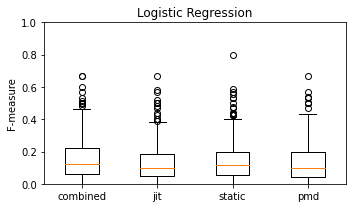

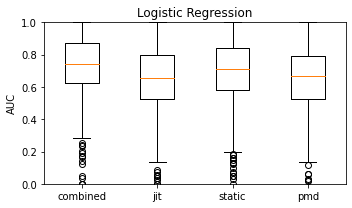

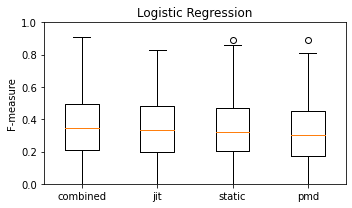

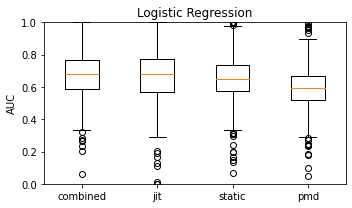

In [3]:
for plot_name, lbl_name in zip(['bug', 'ad-hoc'], ['label_bug', 'label_adhoc']):
    for pn1, ms1 in [('F-measure', 'lr_f1'), ('AUC', 'lr_roc_auc')]:
        fig = plt.figure(figsize=(5,3))
        ax = fig.add_subplot(111)
        plt.title('Logistic Regression')
        bp = []
        names = []
        for pn, ms in [('combined', 'jit_static_pmd'), ('jit', 'jit'), ('static', 'static'), ('pmd', 'pmd')]:
            bp.append(r[(r['metric_set'] == ms) & (r['label'] == lbl_name)][ms1].values)
            names.append(pn)
        ax.boxplot(bp)
        ax.set_xticklabels(names)
        ax.set_ylabel(pn1)
        ax.set_ylim([0,1])
        #plt.show()
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + '/interval_mean_{}_{}.pdf'.format(ms1, lbl_name))

# Random forest interval plots

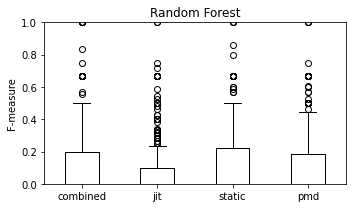

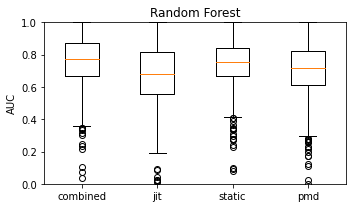

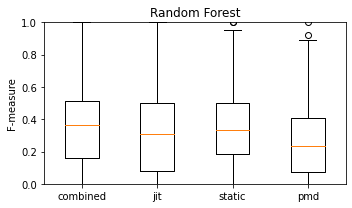

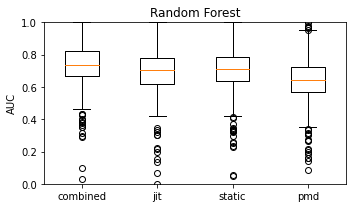

In [4]:
for plot_name, lbl_name in zip(['bug', 'ad-hoc'], ['label_bug', 'label_adhoc']):
    for pn1, ms1 in [('F-measure', 'rf_f1'), ('AUC', 'rf_roc_auc')]:
        fig = plt.figure(figsize=(5,3))
        ax = fig.add_subplot(111)
        plt.title('Random Forest')
        bp = []
        names = []
        for pn, ms in [('combined', 'jit_static_pmd'), ('jit', 'jit'), ('static', 'static'), ('pmd', 'pmd')]:
            bp.append(r[(r['metric_set'] == ms) & (r['label'] == lbl_name)][ms1].values)
            names.append(pn)
        ax.boxplot(bp)
        ax.set_xticklabels(names)
        ax.set_ylabel(pn1)
        ax.set_ylim([0,1])
        # plt.show()
        plt.tight_layout()
        plt.savefig(FIGURES_PATH + '/interval_mean_{}_{}.pdf'.format(ms1, lbl_name))

# Cost model

In [5]:
dats = []
for project in r['project'].unique():
    for plot_name, lbl_name in zip(['bug', 'adhoc'], ['label_bug', 'label_adhoc']):
        df = r[(r['label'] == lbl_name) & (r['metric_set'] != 'jit_statc') & (r['project'] == project)].copy()
        for metric_set in df['metric_set'].unique():
            tmp = df[df['metric_set'] == metric_set]
            dats.append({'classifier': 'Random Forest', 'project': project, 'feature_set': metric_set, 'ub': tmp['rf_ub'].values[0], 'lb': tmp['rf_lb'].values[0], 'label': plot_name})
            dats.append({'classifier': 'Logistic Regression', 'project': project, 'feature_set': metric_set, 'ub': tmp['lr_ub'].values[0], 'lb': tmp['lr_lb'].values[0], 'label': plot_name})

test = pd.DataFrame(dats)

print('projects', test['project'].nunique())
for label in test['label'].unique():
    for ms in test['feature_set'].unique():
        if ms not in ['jit', 'jit_static_pmd']:
            continue
        for cl in test['classifier'].unique():
            tmp = test[(test['label'] == label) & (test['classifier'] == cl) & (test['feature_set'] == ms) & (np.isfinite(test['ub'])) & (np.isfinite(test['lb'])) & (test['ub'] > test['lb'])]
            s = np.sum(tmp['ub'] - tmp['lb'])
            print(label, ms, cl, len(tmp))

projects 38
bug jit Random Forest 4
bug jit Logistic Regression 11
bug jit_static_pmd Random Forest 6
bug jit_static_pmd Logistic Regression 11
adhoc jit Random Forest 10
adhoc jit Logistic Regression 13
adhoc jit_static_pmd Random Forest 16
adhoc jit_static_pmd Logistic Regression 14


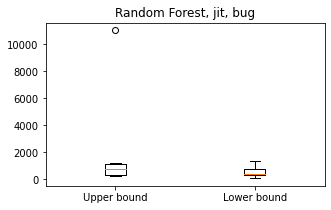

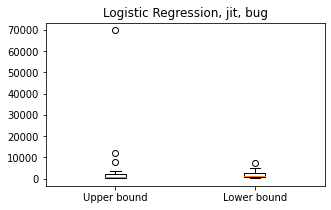

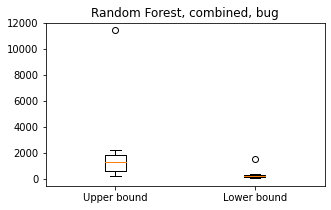

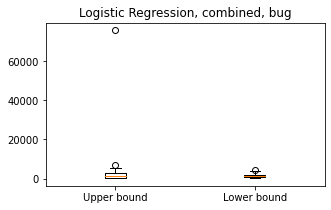

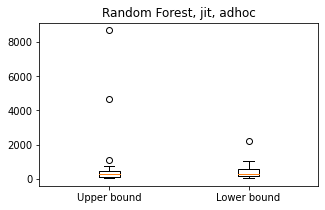

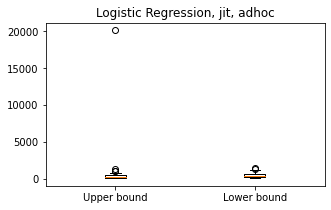

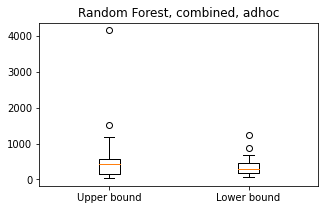

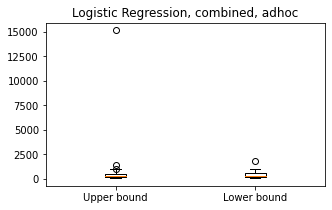

In [6]:
for label in test['label'].unique():
    for ms in test['feature_set'].unique():
        if ms not in ['jit', 'jit_static_pmd']:
            continue
        plot_name = 'jit'
        if ms == 'jit_static_pmd':
            plot_name = 'combined'
        for cl in test['classifier'].unique():
            short_name = 'lr'
            if cl == 'Random Forest':
                short_name = 'rf'
            
            fig = plt.figure(figsize=(5,3))
            ax = fig.add_subplot(111)
            plt.title('{}, {}, {}'.format(cl, plot_name, label))
            tmp = test[(test['label'] == label) & (test['classifier'] == cl) & (test['feature_set'] == ms) & (np.isfinite(test['ub']) & (np.isfinite(test['lb'])))]  # select ONLY finite bounds!
            
            bp = []
            names = []
            bp.append(tmp['ub'].values)
            names.append('Upper bound')
            bp.append(tmp['lb'].values)
            names.append('Lower bound')

            ax.boxplot(bp)    
            ax.set_xticklabels(names)
            #plt.tight_layout()
            #plt.savefig(FIGURES_PATH + '/interval_bounds_{}_{}_{}.pdf'.format(short_name, plot_name, label))
            plt.show()